In [15]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1️⃣ 데이터 로드
file_path = "/content/drive/MyDrive/Colab Notebooks/Alcohol_Sales.csv"
df = pd.read_csv(file_path)
data = df['S4248SM144NCEN'].values.reshape(-1,1)

In [16]:
df

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


In [17]:
# 2️⃣ 정규화
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [18]:
# 3️⃣ 시퀀스 생성 함수
def make_sequence(data, window=12):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window = 12
X, y = make_sequence(data, window)

In [19]:
# 4️⃣ train / test 분리 (80% 학습, 20% 테스트)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (250, 12, 1), Test size: (63, 12, 1)


In [20]:
# 5️⃣ 모델 1: Simple RNN
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=(window,1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# 6️⃣ 모델 2: LSTM
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window,1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)

In [22]:
# 7️⃣ 예측
rnn_pred = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


In [23]:
# 8️⃣ 역정규화
y_test_inv = scaler.inverse_transform(y_test)
rnn_pred_inv = scaler.inverse_transform(rnn_pred)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)

In [24]:
# 9️⃣ MSE 계산
rnn_mse = mean_squared_error(y_test_inv, rnn_pred_inv)
lstm_mse = mean_squared_error(y_test_inv, lstm_pred_inv)

print(f"✅ RNN MSE: {rnn_mse:.4f}")
print(f"✅ LSTM MSE: {lstm_mse:.4f}")

✅ RNN MSE: 1018493.5301
✅ LSTM MSE: 2379639.5381


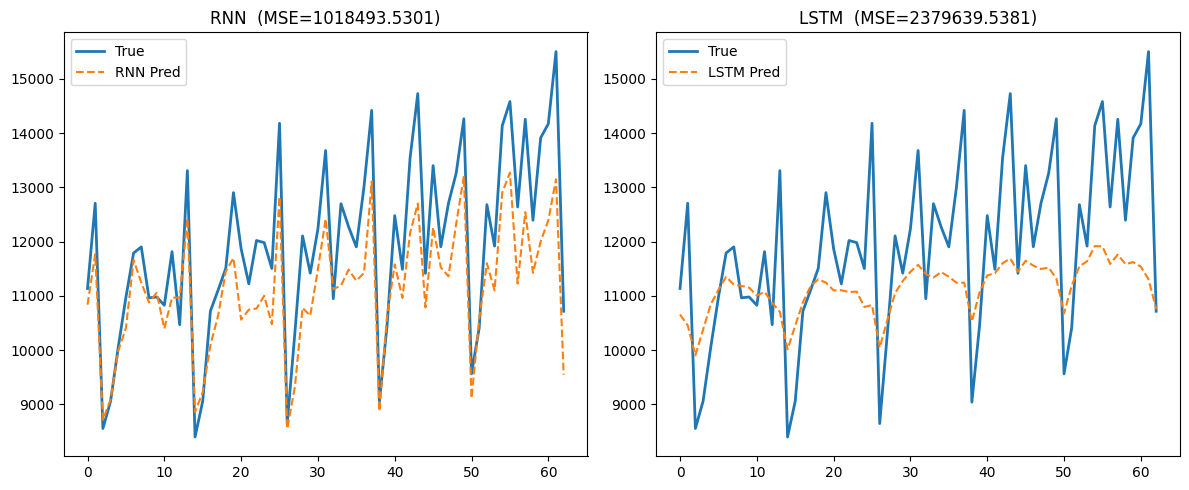

In [26]:
# 🔟 시각화
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(y_test_inv, label='True', linewidth=2)
plt.plot(rnn_pred_inv, label='RNN Pred', linestyle='--')
plt.title(f'RNN  (MSE={rnn_mse:.4f})')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_test_inv, label='True', linewidth=2)
plt.plot(lstm_pred_inv, label='LSTM Pred', linestyle='--')
plt.title(f'LSTM  (MSE={lstm_mse:.4f})')
plt.legend()

plt.tight_layout()
plt.show()